# RESNET50 구현

## Library 선언

In [ ]:
# Download dataset
import os
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

# numpy / pytorch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Preparing batch data
from torchvision.datasets import ImageFolder
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# plotting
import matplotlib
import matplotlib.pyplot as plt

# Training
from tqdm import tqdm
import torch.optim as optim

%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda')

## Prepare Dataset

In [ ]:
# Dowload the dataset CIFAR 10
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')
    
# Look into the data directory
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

  0%|          | 0/135107811 [00:00<?, ?it/s]

['train', 'test']
['horse', 'ship', 'automobile', 'cat', 'dog', 'airplane', 'deer', 'bird', 'truck', 'frog']


아래 코드에 필요한 Augmentation을 채워 넣어주세요.
- image resize

CIFAR 10은 32x32x3의 구조를 가집니다. 하지만 Resnet은 224 x 224 x 3을 input으로 가집니다.

- transform to tensor


In [ ]:
# Data transforms (normalization & data augmentation)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_transforms = transform.Compose([transform.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         transform.RandomHorizontalFlip(), 

                         ############ 2 lines in here##############
                         transform.Resize(224),
                         transform.ToTensor(),
                         ##########################################

                         transform.Normalize(*stats)
                         ])

test_transforms = transform.Compose([
                         ############ 2 lines in here##############
                         transform.Resize(224),
                         transform.ToTensor(),
                         ##########################################

                         transform.Normalize(*stats)
                         ])

denorm = ((-2.4191, -2.4183, -2.2214), (4.9432, 5.0150, 4.9751))

In [ ]:
train_ds = ImageFolder(data_dir+'/train', train_transforms)
test_ds = ImageFolder(data_dir+'/test', test_transforms)

len(train_ds), len(test_ds)

(50000, 10000)

In [ ]:
# train dataset을 train dataset (train_ds) 와 validation dataset (val_ds)으로 나누세요.
val_pct = 0.1

##################### YOUR CODES here 1~3 lines #######################
val_len = int(len(train_ds) * val_pct)
train_len = len(train_ds) - val_len
train_ds, val_ds = random_split(train_ds, [train_len, val_len])
###########################################3###########################

len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
batch_size = 32

#################################### YOUR CODES here 3 lines ############################################
train_dl = DataLoader(train_ds, batch_size= batch_size, num_workers = 2, shuffle = True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size = batch_size, num_workers = 2, shuffle = True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size = batch_size, num_workers = 2, shuffle = True, pin_memory=True)
##########################################################################################################

len(train_dl), len(val_dl), len(test_dl)

(1407, 157, 313)

DataLoader의 pin memory

If you load your samples in the Dataset on CPU and would like to push it during training to the GPU, you can speed up the host to device transfer by enabling pin_memory.
This lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.
You can find more information on the
https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

In [ ]:
### Test ###
if (len(train_dl) == 1407 and len(val_dl) == 157 and len(test_dl) == 313) :
  print("success")
else:
  raise AssertionError("shape mismatch")

success


## RESNET 50 model

RESNET은 대표적인 CNN macro-architecture 중 하나입니다. 여기서 macro-architecture가 의미하는 바는, 
모델의 부분을 CNN micro-architecture라고 한다면 input부터 끝까지 전체 구조를 CNN macro-architecture이라고 합니다. 이러한 CNN macro-architecture로는 VGGNet, ResNet, DenseNet 등 여러 모델들이 존재합니다. 대표적인 예시로 skip connection의 유무가 cnn macroarchitecture라고 할 수 있습니다.

_______________________________________________________________________________________________

Resnet의 Idea
2014년 Imagenet Challenge에서 VGGNet은 GoogLeNet과 함께 주목 받았고, 간단한 구조와 단일 network에서 좋은 성능을 보여주는 이유로 인해 1위를 차지한 GoogLeNet보다 더 많은 주목을 받았습니다.

이떼 VGGNet에서 network가 깊어질 수록 더 좋은 성능을 가진다는 것을 깨달았습니다. 하지만 이러한 통념과 반대로 실제 network를 깊게 하면 오히려 성능이 떨어지는 현상이 발생하였습니다. model이 커지고 깊어질수록 overfitting이  일어나 test time에서의 성능은 떨어지지만, train time 에서는 성능이 좋아질 것이라 생각한 것과 반대로 둘 다 성능이 떨어졌습니다.

이는 network가 깊어질수록 gradient가 vanishing 하는 현상 때문에 발생하였습니다. **그래서 RESNET에서는 SKIP Connection을 통해 아랫단으로도 gradient가 원할하게 흐를 수 있도록 하였습니다.**

즉 $H(x) = F(x) + x$로 네트워크를 구성하였습니다.
 - $F(x)$ convolution 출력
 - $x$ is input 

이러한 구조는 두가지 장점이 있습니다.

첫 번째는, 이를 통해 Convolution layer의 output이 정확하지 않을 때, F(x)를 0에 가깝게 학습하고 그리고 원래 input x 값을 활용할 수 있게 끔 하였습니다. 이는 Regularization에서 weight를 0으로 가깝게 끔 만드는 것과 유사하게 해석할 수 있습니다. Resnet에서 $F(x)$를 0으로 만드는 건 모델이 불필요한 레이어를 사용하지 않도록 해주는 것이며, 극단적인 경우 $H(x)$는 Identity mapping 역할을 해줍니다.

두 번째로, upstream gradient 관점에서 Addition을 만나게 된다면 gradient는 두 갈래로 나눠지게 됩니다.
- Convolution layer로 흘러 들어감
- Skip connection으로 직접 이전 layer로 흘러 들어감

이로 인해 gradient가 훨씬 원할하게 흐르며, 네트워크가 더 빨리, 더 잘 converge하게 됩니다.


**아래는 RESNET 구조입니다.**

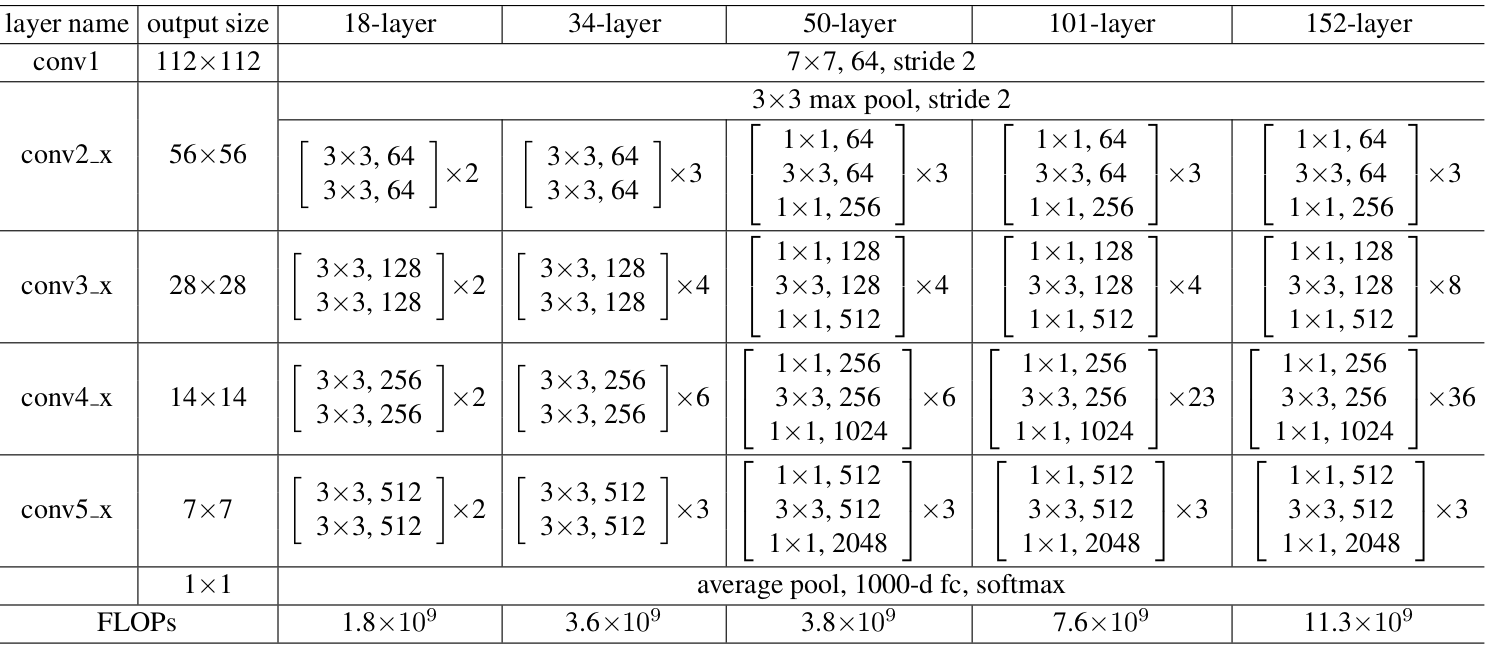

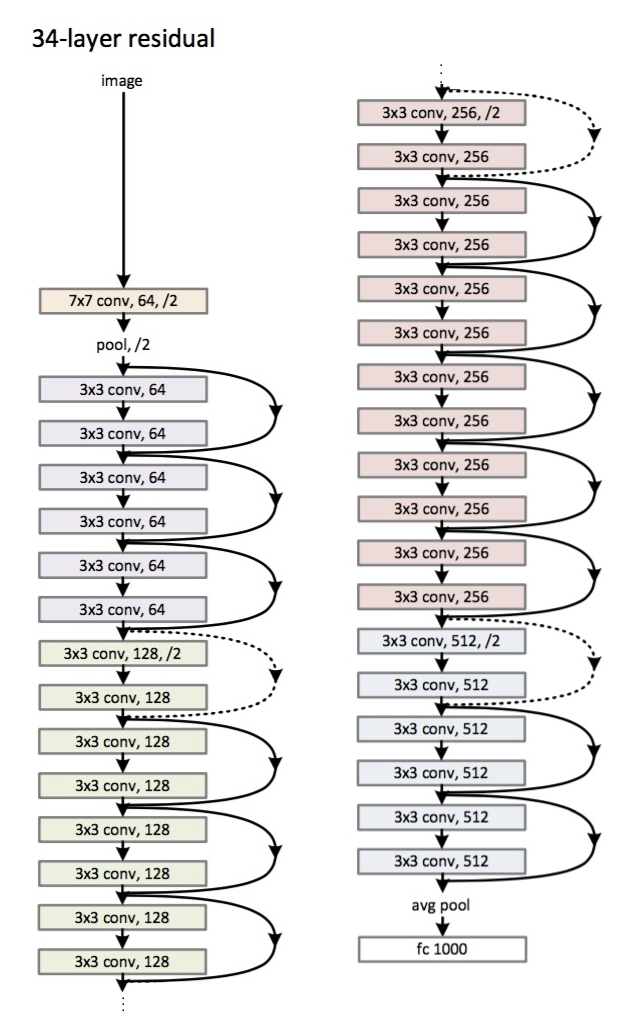

**RESNET Layer**

RESNET 50 구조는 위와 같습니다.

Layer 개수 (5 Layer)
- conv1 : 1
- conv2 : 3 * 3 = 9
- conv3 : 3 * 4 = 12
- conv4 : 3 * 6 = 18
- conv5 : 3 * 3 = 9
- last : 1

sum: 50

각 Convolution layer는 Conv - batch - relu 구조를 가지며, Layer의 첫 block의 처음 convolution layer에서 stride 2로 downsampling 해줍니다. 또한 모든 conv layer의 bias는 존재하지 않습니다. Batchnorm이 bias 역할을 해줍니다.

그리고 각 Layer는 여러 개의 convolutional block으로 이루어져 있습니다. i.e conv2_x 3개의 block






**BLOCK**

이러한 block의 구조는 bottle neck 구조로 1x1 convolution layer를 통해 연산량을 줄여 줍니다.

그 후 매 block마다 Skip Connection을 거친 후 ReLU activation function을 통과시킵니다. 이 때 2가지 경우가 존재합니다.
- Identity block: input과 output이 같은 구조로 input을 그대로 더 해 주면 됩니다.
- Convolution block: Input과 output의 shape를 맞춰주기 위해 추가적인 convolution 연산이 필요합니다.

**Resnet50 같은 경우 4개의 Convolution block과 12개의 Identity block이 존재합니다.**

i.e) conv3_x resnet 50 convolutional block
- layer1: conv(input, middle, 1, stride) -> batch -> relu
- layer2: conv(middle, middle, 3) -> batch -> relu
- layer3: conv(middle, out, 1) -> batch -> relu
- relu(layer4 + conv(x))

Skip connection을 구현할 때 inplace 연산에 유의하세요 !!

뒤에서 input에 선언했던 변수를 덮어 씌워 버리는 등등


In [ ]:
class Bottleneck(nn.Module):
  def __init__(self, input_dim, middle_dim, output_dim, conv_block = False, stride = 2):
    super(Bottleneck, self).__init__()

    self.conv_block = conv_block

    ################### Your code here ##############################
    self.layer1 = nn.Sequential(
        nn.Conv2d(input_dim, middle_dim, 1, stride, 0, bias = False),
        nn.BatchNorm2d(middle_dim),
        nn.ReLU()
    )
    
    self.layer2 = nn.Sequential(
        nn.Conv2d(middle_dim, middle_dim, 3, 1, 1, bias = False),
        nn.BatchNorm2d(middle_dim),
        nn.ReLU()
    )

    if self.conv_block:
      self.convolution_block = nn.Sequential(
          nn.Conv2d(input_dim, output_dim, 1, stride, 0, bias = False),
          nn.BatchNorm2d(output_dim)
        )

    self.layer3 = nn.Sequential(
        nn.Conv2d(middle_dim, output_dim, 1, 1, 0, bias = False),
        nn.BatchNorm2d(output_dim),
        nn.ReLU()
      )
    
    ################################################################


  def forward(self, x):
    shortcut = x

    ################## YOUR CODES HERE 6 ~ 9 lines ##################
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)

    if self.conv_block:
      shortcut = self.convolution_block(shortcut)

    out = out + shortcut
    out = F.relu(out)
    #################################################################

    return out

In [ ]:
### Now Testing ###
import torchsummary

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
x = torch.randn([1, 256, 112, 112]).to(device)


model = Bottleneck(256, 128, 512, True, 2).to(device)

if model(x).shape == (1, 512, 56, 56):
  print("pass convolutional block")
else:
  raise AssertionError("convolutional block shape mismatch")

x = model(x)

model = Bottleneck(512, 128, 512, False, 1).to(device)
if model(x).shape == (1, 512, 56, 56):
  print("pass Identity block")
else:
  raise AssertionError("Identity block shape mismatch")

x = model(x)


if count_parameters(model) == 280064:
  print("pass parameters block")
else:
  raise AssertionError("parameters mismatch")

torchsummary.summary(model, (512, 56, 56))

pass convolutional block
pass Identity block
pass parameters block
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]          65,536
       BatchNorm2d-2          [-1, 128, 56, 56]             256
              ReLU-3          [-1, 128, 56, 56]               0
            Conv2d-4          [-1, 128, 56, 56]         147,456
       BatchNorm2d-5          [-1, 128, 56, 56]             256
              ReLU-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 512, 56, 56]          65,536
       BatchNorm2d-8          [-1, 512, 56, 56]           1,024
              ReLU-9          [-1, 512, 56, 56]               0
Total params: 280,064
Trainable params: 280,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 6.12
Forward/backward pass size (MB): 55.12
Params size (MB): 1.07
Estimat

**위에서 만든 Residual Block으로 Resnet50를 만들어 보세요**

단 마지막 layer의 output은 (-1, 10) 으로 합니다. (CIFAR10)

In [ ]:
class Resnet50(nn.Module):
  def __init__(self, out_dim):
    super(Resnet50, self).__init__()

    ################### Your code here ####################
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, 7, 2, 3, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )

    self.conv2_x = nn.Sequential(
        nn.MaxPool2d(3, stride = 2, padding= 1),
        Bottleneck(64, 64, 256, True, 1),
        Bottleneck(256, 64, 256, False, 1),
        Bottleneck(256, 64, 256, False, 1)
    )

    self.conv3_x = nn.Sequential(
        Bottleneck(256, 128, 512, True, 2),
        Bottleneck(512, 128, 512, False, 1),
        Bottleneck(512, 128, 512, False, 1),
        Bottleneck(512, 128, 512, False, 1)
    )

    self.conv4_x = nn.Sequential(
        Bottleneck(512, 256, 1024, True, 2),
        Bottleneck(1024, 256, 1024, False, 1),
        Bottleneck(1024, 256, 1024, False, 1),
        Bottleneck(1024, 256, 1024, False, 1),
        Bottleneck(1024, 256, 1024, False, 1),
        Bottleneck(1024, 256, 1024, False, 1)
    )

    self.conv5_x = nn.Sequential(
        Bottleneck(1024, 512, 2048, True, 2),
        Bottleneck(2048, 512, 2048, False, 1),
        Bottleneck(2048, 512, 2048, False, 1)
    )

    self.AvgPool2d = nn.AdaptiveAvgPool2d(1)

    self.Linear = nn.Linear(2048, out_dim)
    ######################################################

  def forward(self,x):

    ################ Your code here 7~8 ###################
    out = self.conv1(x)
    out = self.conv2_x(out)
    out = self.conv3_x(out)
    out = self.conv4_x(out)
    out = self.conv5_x(out)
    out = self.AvgPool2d(out)
    out = out.squeeze()
    out = self.Linear(out)
    #######################################################

    return out

In [ ]:
## Testing ##
model = Resnet50(1000).to(device)


if count_parameters(model) == 25557032:
  print("pass parameters block")
else:
  raise AssertionError("parameters mismatch")

torchsummary.summary(model, (3, 224, 224))

pass parameters block
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d

## Training

In [ ]:
class Trainer():
  def __init__(self, model, train, val, criterion, optim_fn, lr, device):
    self.model = model
    self.criterion = criterion
    self.optimizer = optim_fn(self.model.parameters(), lr)
    self.train_dl = train
    self.val_dl = val
    self.device = device
    self.train_loss = []
    self.train_acc = []
    self.valid_loss = []
    self.valid_acc = []

  def train(self, epochs =1):
    self.model = self.model.to(self.device)

    for i in range(epochs):
      print('Epoch : ', i)
      loss = 0.0
      acc = 0.0

      print("'''''Training'''''")
      # Set train mode
      self.model.train()

      # tqdm
      with tqdm(self.train_dl, unit = 'batch') as train_dl:
        for X, y in train_dl:


          ################### Your code here ####################
          ## Data on GPU
          X = X.to(self.device, non_blocking = True)
          y = y.to(self.device, non_blocking = True)

          ## Set Gradient = 0
          self.optimizer.zero_grad()

          ## Calculate loss
          out = self.model(X)
          batch_loss = self.criterion(out, y)

          ## Gradient Step
          batch_loss.backward()
          self.optimizer.step()
          
          with torch.no_grad():
            loss += batch_loss.item()
            _, pred = torch.max(out, dim = 1)
            acc += torch.sum(pred == y).item() / len(y)
          ########################################################


          train_dl.set_postfix(loss = loss / len(train_dl), accuracy = 100.0 * acc / len(train_dl))

        self.train_loss.append(loss / len(train_dl))
        self.train_acc.append(100.0 * acc / len(train_dl))
        
        # set Validation mode
        print("'''Validation'''")
        self.model.eval()

        with torch.no_grad():
          with tqdm(self.val_dl, unit = 'batch') as val_dl:
            val_loss = 0.0
            val_acc = 0.0 
            ################### Your code here ####################
            for X, y in val_dl:
              X = X.to(self.device)
              y = y.to(self.device)

              out = self.model(X)

              val_loss += self.criterion(out, y).item()

              _, pred = torch.max(out, dim =1)
              
              val_acc += torch.sum(pred == y).item() / len(y)

              ######################################################
              val_dl.set_postfix(loss = val_loss / len(val_dl), accuracy = 100.0 * val_acc / len(val_dl))
              
            self.valid_loss.append(val_loss / len(val_dl))
            self.valid_acc.append(100.0 * val_acc / len(val_dl))


    return {'train_history' : (self.train_loss, self.train_acc), 'valid_history' : (self.valid_loss, self.valid_acc)}
            

In [ ]:
model = Resnet50(10)
criterion = F.cross_entropy
optimizer = optim.Adam

trainer = Trainer(model, train_dl, val_dl, criterion, optimizer, 5e-4, device)


In [ ]:
history = trainer.train(10)

Epoch :  0
'''''Training'''''


100%|██████████| 1407/1407 [14:51<00:00,  1.58batch/s, accuracy=40.9, loss=1.6]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.93batch/s, accuracy=52.1, loss=1.32]


Epoch :  1
'''''Training'''''


100%|██████████| 1407/1407 [14:53<00:00,  1.58batch/s, accuracy=59.5, loss=1.14]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.93batch/s, accuracy=60.8, loss=1.19]


Epoch :  2
'''''Training'''''


100%|██████████| 1407/1407 [14:53<00:00,  1.58batch/s, accuracy=66.8, loss=0.941]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.91batch/s, accuracy=65.6, loss=1.02]


Epoch :  3
'''''Training'''''


100%|██████████| 1407/1407 [14:52<00:00,  1.58batch/s, accuracy=71, loss=0.821]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.93batch/s, accuracy=71.7, loss=0.776]


Epoch :  4
'''''Training'''''


100%|██████████| 1407/1407 [14:52<00:00,  1.58batch/s, accuracy=74.7, loss=0.722]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.94batch/s, accuracy=71.9, loss=0.812]


Epoch :  5
'''''Training'''''


100%|██████████| 1407/1407 [14:53<00:00,  1.57batch/s, accuracy=78.1, loss=0.637]


'''Validation'''


100%|██████████| 157/157 [00:32<00:00,  4.91batch/s, accuracy=73.4, loss=0.779]


Epoch :  6
'''''Training'''''


100%|██████████| 1407/1407 [14:55<00:00,  1.57batch/s, accuracy=79.7, loss=0.584]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.91batch/s, accuracy=77.4, loss=0.713]


Epoch :  7
'''''Training'''''


100%|██████████| 1407/1407 [14:54<00:00,  1.57batch/s, accuracy=81.5, loss=0.541]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.92batch/s, accuracy=82.1, loss=0.52]


Epoch :  8
'''''Training'''''


100%|██████████| 1407/1407 [14:53<00:00,  1.58batch/s, accuracy=83, loss=0.493]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.93batch/s, accuracy=81.8, loss=0.527]


Epoch :  9
'''''Training'''''


100%|██████████| 1407/1407 [14:51<00:00,  1.58batch/s, accuracy=84.1, loss=0.458]


'''Validation'''


100%|██████████| 157/157 [00:31<00:00,  4.93batch/s, accuracy=84.8, loss=0.441]


In [ ]:
def plot_accuracies(history):
  train_loss, train_acc = history['train_history']
  val_loss, val_acc = history['valid_history']
  plt.plot(train_acc, '-bx')
  plt.plot(val_acc, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(['Training', 'Validation'])
  plt.title('Accuracy vs. No. of epochs');

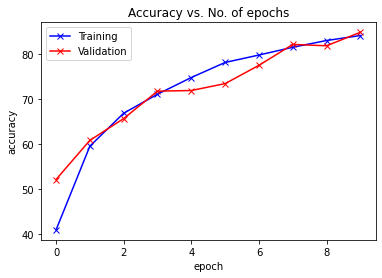

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_loss, train_acc = history['train_history']
    val_loss, val_acc = history['valid_history']

    plt.plot(train_loss, '-bx')
    plt.plot(val_loss, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

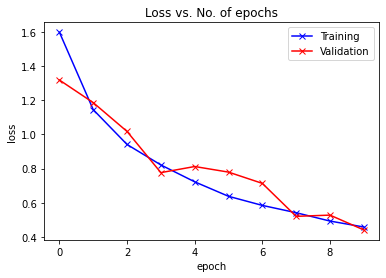

In [ ]:
plot_losses(history)

## Testing

고생하셨습니다. 그럼 만든 모델을 test 해 보죠!

In [ ]:
class Testing():
  def __init__(self, model, test_loader, device):
    self.model = model
    self.test_loader = test_loader
    self.device = device

  def test(self):
    self.model = self.model.to(device)
    with tqdm(self.test_loader, unit = 'batch') as test_dl:
      self.model.eval()

      acc =0.0
      
      for X, y in test_dl:
        with torch.no_grad():
          
          ################### Your code here ####################
          X = X.to(self.device, non_blocking= True)
          y = y.to(self.device, non_blocking= True)

          out = self.model(X)
            
          _, pred = torch.max(out, dim=1)

          acc += torch.sum(pred == y).item() / len(y)
          ######################################################
          
          test_dl.set_postfix(accuracy = 100 * acc / len(test_dl))

In [ ]:
testing = Testing(model, test_dl, device)

testing.test()

100%|██████████| 313/313 [01:04<00:00,  4.87batch/s, accuracy=84.7]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def predict_image(img, model, device):
    xb = img.to(device)
    model = model.to(device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim = 0)
    return preds.item()

Label: 3 , Predicted: 3


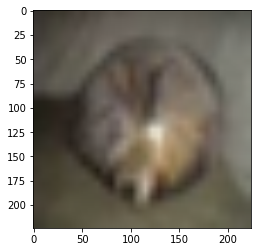

In [ ]:
img, label = test_ds[3200]
img = img.unsqueeze(0)
print('Label:', label, ', Predicted:', predict_image(img, model, device))
tt = transform.Normalize(*denorm)
img = tt(img).squeeze(0)
plt.imshow(img.permute(1,2, 0))

Label: 0 , Predicted: 0


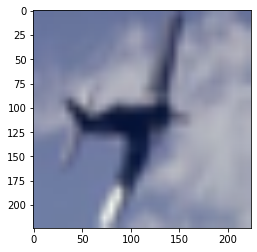

In [ ]:
img, label = test_ds[11]
img = img.unsqueeze(0)
print('Label:', label, ', Predicted:', predict_image(img, model, device))
tt = transform.Normalize(*denorm)
img = tt(img).squeeze(0)
plt.imshow(img.permute(1,2, 0))

## Save / Load

만든 model을 저장하고 불러와 보세요

In [ ]:
list(model.named_parameters())[0][1][:10, 0, 0]

tensor([[-0.0377,  0.1100,  0.0757,  0.0336,  0.1016,  0.0450, -0.0297],
        [-0.1270, -0.0077, -0.0274, -0.0036, -0.0956, -0.0696,  0.0048],
        [ 0.0484, -0.0117,  0.0153,  0.0499,  0.0099, -0.0626,  0.0581],
        [-0.0285, -0.0166, -0.0300, -0.0240,  0.0691,  0.0026, -0.0054],
        [ 0.0013,  0.0576,  0.0518,  0.0479,  0.0154,  0.1022,  0.0791],
        [ 0.0273,  0.0086,  0.0269,  0.0601,  0.0347,  0.0217,  0.0235],
        [ 0.0708,  0.0421,  0.0368, -0.0540,  0.0686,  0.0950, -0.0207],
        [-0.0035, -0.0626,  0.0292, -0.0521,  0.0062, -0.0287, -0.0778],
        [-0.0304, -0.0645, -0.0279, -0.0920, -0.0299, -0.0994, -0.0322],
        [-0.0768, -0.0620, -0.0846, -0.1342, -0.0492, -0.0651, -0.0814]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
torch.save(model.state_dict(), f='./Resnet50.pth')

In [ ]:
model2 = Resnet50(10).to(device)
list(model2.named_parameters())[0][1][:10, 0, 0]

tensor([[ 7.7238e-02,  6.9104e-03, -6.3981e-02, -6.4049e-02, -5.0099e-02,
          4.3235e-02,  5.4099e-02],
        [-1.0851e-02, -6.6827e-02,  7.2349e-02,  8.5181e-04,  1.3884e-02,
         -7.8021e-02,  7.0310e-02],
        [-2.8002e-02,  2.6125e-02, -7.7661e-02, -7.5856e-03, -5.6133e-02,
          3.4672e-02,  7.9270e-02],
        [ 1.5330e-02,  5.4035e-04,  1.2724e-02,  5.0750e-02, -7.4137e-02,
         -5.9853e-02,  2.1733e-02],
        [-9.0907e-03,  2.8052e-02, -5.2664e-02,  7.0100e-02,  7.5806e-02,
          3.6216e-02, -5.3262e-02],
        [ 4.3150e-02,  8.1786e-02, -5.8838e-02,  2.7239e-02,  7.0650e-02,
         -7.8776e-02, -4.8962e-02],
        [ 2.0685e-02,  4.9390e-02, -1.2708e-02, -3.1761e-02,  5.8373e-02,
          3.1360e-02,  7.7746e-02],
        [-1.7970e-02,  7.7610e-02,  1.5978e-03, -4.6349e-02, -7.9776e-02,
         -4.9020e-02,  3.4867e-02],
        [ 6.5662e-02,  5.3421e-02,  7.4549e-02, -1.4189e-02,  2.0404e-03,
         -9.1145e-06,  1.7938e-02],
        [ 

In [ ]:
model2.load_state_dict(torch.load('./Resnet50.pth'))
list(model2.named_parameters())[0][1][:10, 0, 0]

tensor([[-0.0377,  0.1100,  0.0757,  0.0336,  0.1016,  0.0450, -0.0297],
        [-0.1270, -0.0077, -0.0274, -0.0036, -0.0956, -0.0696,  0.0048],
        [ 0.0484, -0.0117,  0.0153,  0.0499,  0.0099, -0.0626,  0.0581],
        [-0.0285, -0.0166, -0.0300, -0.0240,  0.0691,  0.0026, -0.0054],
        [ 0.0013,  0.0576,  0.0518,  0.0479,  0.0154,  0.1022,  0.0791],
        [ 0.0273,  0.0086,  0.0269,  0.0601,  0.0347,  0.0217,  0.0235],
        [ 0.0708,  0.0421,  0.0368, -0.0540,  0.0686,  0.0950, -0.0207],
        [-0.0035, -0.0626,  0.0292, -0.0521,  0.0062, -0.0287, -0.0778],
        [-0.0304, -0.0645, -0.0279, -0.0920, -0.0299, -0.0994, -0.0322],
        [-0.0768, -0.0620, -0.0846, -0.1342, -0.0492, -0.0651, -0.0814]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
## 실제 renet50와 비교해보세요##
from torchvision.models.resnet import resnet50

resnet = resnet50().to(device)

In [ ]:
torchsummary.summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
your_model = Resnet50(1000).to(device)
torchsummary.summary(your_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
             ReLU-13          [-1, 256, 56, 56]               0
           Conv2d-14          [-1, 256,

In [ ]:
from google.colab import files

files.download('./Resnet50.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>